In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['figure.dpi'] = 200
plt.style.use('ggplot')

Our goal is to predict a target value $y$ from a vector input variables $\mathbf{x} = [x^1, x^2, \cdots, x^M]$.

For example, $y$ is the mid-price of AAPL at next time step (1 second per time step) and $\mathbf{x}$ is limit order book data.

Suppose that we are given many examples $\mathcal{D}_{train} = (\mathbf{x}_n, y_n)_{n=1}^N$, where $n$ represents the $n$-th sample.

We want to find a function $\hat{y} = f(\mathbf{x})$ so that we have $y \approx \hat{y}$ for any $\mathbf{x}$.

First, we must decide the form of $f(\mathbf{x})$.

We start from linear functions: $f_{\theta}(\mathbf{x}) = \sum_{j=1}^M \theta_j x^j = \boldsymbol{\theta}^{\top}\mathbf{x}$.

In [28]:
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
dtype = torch.float

theta_1 = torch.zeros((), device=device, dtype=dtype, requires_grad=True)
theta_2 = torch.zeros((), device=device, dtype=dtype, requires_grad=True)

def linear_model(
    x: torch.Tensor
):
    return theta_1 * x[:, 0] + theta_2 * x[:, 1]

With this linear form of $f(\cdot)$, our task is to find $\boldsymbol{\theta}$ so that $f_{\theta}(\mathbf{x}_n)$ is as close as possible to $y_n$.

We translate our goal to an object function (a.k.a. loss function). We will search for $\boldsymbol{\theta}$ that optimize that object function:

$$\mathcal{L}(\boldsymbol{\theta}) = \frac{1}{2}\sum_{n=1}^N(f_{\theta}(\mathbf{x}_n) - y_n)^2 = \frac{1}{2} \sum_{n=1}^N(\boldsymbol{\theta}^{\top} \mathbf{x}_n - y_n)^2$$

In [29]:
def mean_squared_error(
    y_pred: torch.Tensor, 
    y: torch.Tensor,
    ):
    return (y_pred - y).pow(2).sum()

There are many algorithms for optimizing the object function.

Linear models with mean squared error object function can be solved analytically.

However, analytical solutions do no exist in most cases.

We introduce an easy and general method to minimize any differentiable loss function.

Gradient descent is an optimization algorithm to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative gradient.

The gradient with respect to model parameters $\boldsymbol{\theta}$

$$
\nabla_{\boldsymbol{\theta}} \mathcal{L}(\boldsymbol{\theta}) = \left[\begin{array}{c}
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_1}\\
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_i}\\
\vdots\\
\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_M}
\end{array}
\right]
$$

Specifically, 

$$\frac{\partial  \mathcal{L}(\boldsymbol{\theta})}{\partial \theta_j} = \sum_{n=1}^N x_n^j (\boldsymbol{\theta}^{\top} \mathbf{x} - y_n)$$

In [30]:
# generate some toy data
# y = 0.4 * x_1 - 0.7 * x_2 + noise

x = np.random.randn(2000, 2)
y = 0.4 * x[:, 0] - 0.7 * x[:, 1] + np.random.randn(2000) * 0.1

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
dtype = torch.float

x_train = torch.tensor(x[:1000], device=device, dtype=dtype)
y_train = torch.tensor(y[:1000], device=device, dtype=dtype)

x_test = torch.tensor(x[1000:], device=device, dtype=dtype)
y_test = torch.tensor(y[1000:], device=device, dtype=dtype)

In [31]:
learning_rate = 1e-4

loss_list = []
theta_1_list = []
theta_2_list = []
theta_1_list.append(theta_1.item())
theta_2_list.append(theta_2.item())


for t in range(200):
    # forward pass
    # y_hat = f(x)
    y_pred = linear_model(x_train)

    # compute the loss 
    loss = (y_pred - y_train).pow(2).sum()

    # backward pass
    # it automatically computes the gradient with respect to the parameters
    loss.backward()

    with torch.no_grad():
        # update model parameters along the direction of negative gradient
        theta_1 -= learning_rate * theta_1.grad
        theta_2 -= learning_rate * theta_2.grad

        # manually zero out the gradients
        theta_1.grad = None
        theta_2.grad = None

    loss_list.append(loss.item())
    theta_1_list.append(theta_1.item())
    theta_2_list.append(theta_2.item())

print('theta_1 :', theta_1.item())
print('theta_2 :', theta_2.item())

theta_1 : 0.3947446048259735
theta_2 : -0.7074931263923645


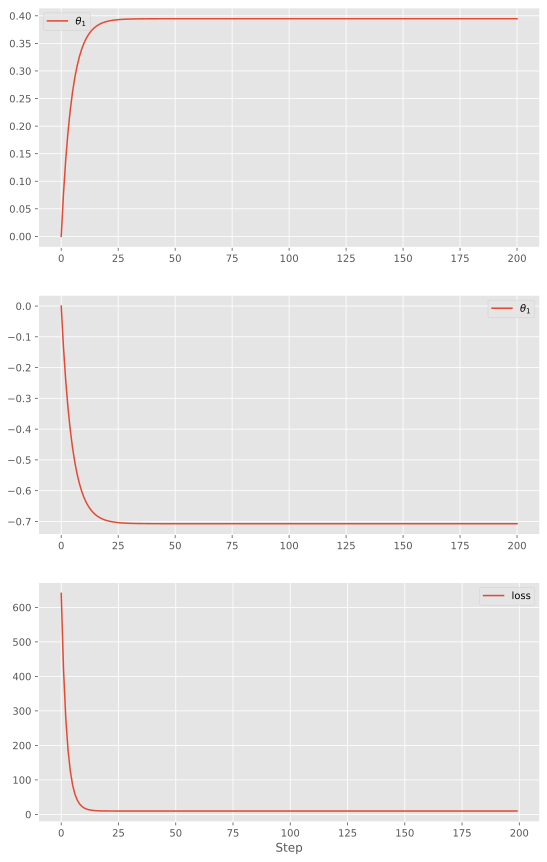

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(9, 15))
axes[0].plot(theta_1_list, label=r'$\theta_1$')
axes[0].legend()
axes[1].plot(theta_2_list, label=r'$\theta_1$')
axes[1].legend()
axes[2].plot(loss_list, label='loss')
axes[2].legend()
axes[2].set_xlabel('Step')
plt.show()